# Reddit Climate Change
Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

## Project Understanding
- Research question / project goal --> will be set after first data investigation and group discussion
- Legal limitations? Privacy limitations?
- Who is giving the name to a subreddit; the author of the subreddit?
- Are there @ mentions in reddit posts?

### Information from Kaggle
- All the posts and comments on Reddit mentioning the terms "climate" and "change"
- The data does not include usernames

### Analysis Ideas:
- Sentiment analysis (basic)
- Bot/troll detection (advanced)
- Something with network analysis (joining posts and comments if possible)
- Use reddit API to get more features


In [ ]:
# Preparing the environment
%pip install pandas
%pip install wordcloud
%pip install nltk
%pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Importing data
raw_comments = pd.read_csv('data/the-reddit-climate-change-dataset-comments.csv', nrows=1000) # Sample for start!
raw_posts = pd.read_csv('data/the-reddit-climate-change-dataset-posts.csv', nrows=1000)

## Data Unterstanding

### Comments Dataset

In [6]:
# Checking 'comments' dataset structure
raw_comments.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,imlddn9,2qh3l,news,False,1661990368,https://old.reddit.com/r/news/comments/x2cszk/...,Yeah but what the above commenter is saying is...,0.5719,2
1,comment,imldbeh,2qn7b,ohio,False,1661990340,https://old.reddit.com/r/Ohio/comments/x2awnp/...,Any comparison of efficiency between solar and...,-0.9877,2
2,comment,imldado,2qhma,newzealand,False,1661990327,https://old.reddit.com/r/newzealand/comments/x...,I'm honestly waiting for climate change and th...,-0.1143,1
3,comment,imld6cb,2qi09,sacramento,False,1661990278,https://old.reddit.com/r/Sacramento/comments/x...,Not just Sacramento. It's actually happening a...,0.0000,4
4,comment,imld0kj,2qh1i,askreddit,False,1661990206,https://old.reddit.com/r/AskReddit/comments/x2...,I think climate change tends to get some peopl...,0.6634,1


In [36]:
# Checking datatypes of 'comments' dataset
raw_comments.dtypes

type                              object
id                                object
subreddit.id                      object
subreddit.name                    object
subreddit.nsfw                      bool
created_utc                        int64
permalink                         object
body                              object
sentiment                        float64
score                              int64
converted_created    datetime64[ns, UTC]
created_converted    datetime64[ns, UTC]
created_date                      object
dtype: object

In [25]:
# Convert comments timestamps and create a date column
raw_comments['created_converted'] = pd.to_datetime(raw_comments['created_utc'], utc=True, unit='s')
raw_comments['created_date'] = pd.to_datetime(raw_comments['created_converted']).dt.normalize() # gets rid of the timestamp inside the date

In [34]:
# Latest and earliest collected comment
print("The latest collected comment about 'climate change' is from",max(raw_comments['created_converted'])) 
print("And the earliest is from",min(raw_comments['created_converted'])) 

The latest collected comment about 'climate change' is from 2022-08-31 23:59:28+00:00
And the earliest is from 2022-08-31 16:54:59+00:00


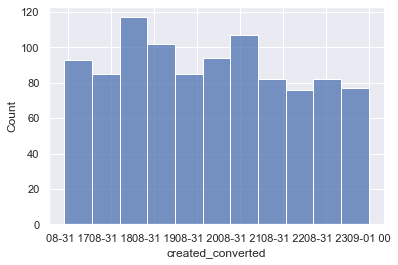

In [26]:
# Distribution of datapoints
sns.set(style="darkgrid")
sns.histplot(data=raw_comments, x="created_converted")
plt.show()

In [38]:
# Comment score summary statistics
print("Max comment score:",max(raw_comments["score"]))
print("Min comment score:",min(raw_comments["score"]))
print('Average comment score:',sum(raw_comments["score"])/len(raw_comments["score"]))

Max comment score: 1255
Min comment score: -64
Average comment score: 9.598


Text(0.5, 1.0, 'comment score distribution')

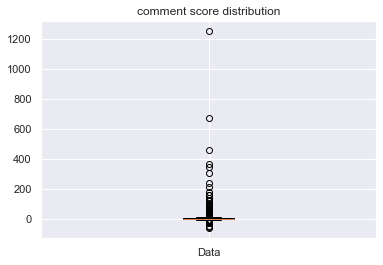

In [41]:
# Comment score boxplot
fig, ax=plt.subplots()
ax.boxplot(raw_comments["score"])

# Labels and title
ax.set_xticklabels(['Data'])
ax.set_title('comment score distribution')

#### Learnings from Comments Dataset
- There is already a sentiment score which goes from -1 to 1, how is it created?
- The data is not equally distributed, there is way less data from the beginning of the tracking and more recent data, also there is a huge peak in the data, probably interesting to be explored
- Maybe sort out comments with a score above 600

### Posts Dataset

In [5]:
# Checking 'posts' dataset structure
raw_posts.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,x2smmw,2vh0v,democraticsocialism,False,1661990237,https://old.reddit.com/r/DemocraticSocialism/c...,twitter.com,https://twitter.com/SusanofTexas/status/156480...,NaN,“Cities without water” is our future. The lead...,15
1,post,x2slxy,2w844,nostupidquestions,False,1661990182,https://old.reddit.com/r/NoStupidQuestions/com...,self.nostupidquestions,NaN,Ok so I was having a conversation with my neig...,Sharks and climate change,2
2,post,x2slk5,6wzx9b,eduwriters,False,1661990150,https://old.reddit.com/r/EduWriters/comments/x...,eduwriters.pro,https://eduwriters.pro/?cid=2860/?utm_source=r...,NaN,How to start a climate change essay,1
3,post,x2sbz6,46adh7,alternatitvereality,False,1661989389,https://old.reddit.com/r/AlternatitveReality/c...,i.imgur.com,https://i.imgur.com/wJbchkQ.jpg,NaN,Ever notice that when it’s hot a few days in J...,1
4,post,x2sa2a,2qh1i,askreddit,False,1661989240,https://old.reddit.com/r/AskReddit/comments/x2...,self.askreddit,NaN,[deleted],How would you react if the next American presi...,1


In [35]:
# Checking datatypes of 'posts' dataset
raw_posts.dtypes

type                              object
id                                object
subreddit.id                      object
subreddit.name                    object
subreddit.nsfw                      bool
created_utc                        int64
permalink                         object
domain                            object
url                               object
selftext                          object
title                             object
score                              int64
created_converted    datetime64[ns, UTC]
dtype: object

In [28]:
# Convert post timestamps and create a date column
raw_posts['created_converted'] = pd.to_datetime(raw_posts['created_utc'], utc=True, unit='s')
raw_posts['created_date'] = pd.to_datetime(raw_posts['created_converted']).dt.normalize() # gets rid of the timestamp inside the date

In [31]:
# Latest and earliest collected post
print("The latest collected post about 'climate change' is from",max(raw_posts['created_converted'])) 
print("And the earliest is from",min(raw_posts['created_converted'])) 


The latest collected post about 'climate change' is from 2022-08-31 23:57:17+00:00
And the earliest is from 2022-08-27 08:27:33+00:00


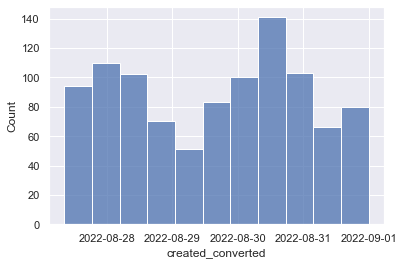

In [32]:
# Distribution of datapoints
sns.set(style="darkgrid")
sns.histplot(data=raw_posts, x="created_converted")
plt.show()

In [70]:
# Post types
distinct_post_types = raw_posts["type"].unique()
print("The posts dataset has only entries of type = 'post'. There is no other type of posts in reddit")

The posts dataset has only entries of type = 'post'. There is no other type of posts in reddit


In [17]:
# Domain types
distinct_domains = raw_posts["domain"].unique()
print("There is ",len(distinct_domains),"different domains in the post dataset")


There is  269 different domains in the post dataset


In [40]:
# Posts score summary statistics
print("Max post score:",max(raw_posts["score"]))
print("Min posts score:",min(raw_posts["score"]))
print('Average post score:',sum(raw_posts["score"])/len(raw_posts["score"]))

Max post score: 104965
Min posts score: 0
Average post score: 160.701


Text(0.5, 1.0, 'posts score distribution')

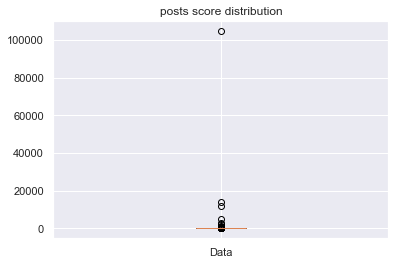

In [39]:
# Post score boxplot
fig, ax=plt.subplots()
ax.boxplot(raw_posts["score"])

# Labels and title
ax.set_xticklabels(['Data'])
ax.set_title('posts score distribution')

#### To Dos, Open Questions and Learnings for Posts Dataset
- Subreddits are comments underneath a main post? 
- Nsfw = "not safe for work"; bad content?
- what does it mean if there is a domain such as twitter? posts get retweeted / reused from other platforms? 
- The data is not equally distributed, there is way less data from the beginning of the tracking and more recent data, also there is a huge peak in the data, probably interesting to be explored, we have way more comment data than post data
- Mabe sort out posts with a score above 20000

## Data Preparation
- Lemmatization

## Modeling / Analysis
- Wordclouds to find content clusters?

## Evaluation

## Deployment
Since this project is only for training purpose there probably won't be a live deployment